In [62]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(stars, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)

options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/pairing/utils.R")
source("src/plot/plot_helpers.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2023-06-30")


In [2]:
stations.scia <- open.dataset("SCIA", "metadata") |>
    collect() |>
    st_md_to_sf()
stations.dpc <- open.dataset("BRUN", "metadata") |>
    filter(flavor == "qc_era5") |>
    collect() |>
    st_md_to_sf()

matches_table <- st_join(
    stations.scia,
    stations.dpc,
    left = FALSE,
    suffix = c(".x", ".y"),
    join = st_is_within_distance,
    dist = units::set_units(5, "km")
) |>
    filter(variable.x == variable.y) |>
    group_by(identifier.x) |>
    mutate(matches.x = n()) |>
    ungroup() |>
    group_by(identifier.y) |>
    mutate(matches.y = n()) |>
    ungroup() |>
    add_distances(stations.scia, stations.dpc) |>
    st_drop_geometry()


In [3]:
matches_table |>
    filter(variable.x == "T_MIN") |>
    nrow()


[1] 6524

In [4]:
prepare_dss <- function(ds, identifier_var, cast_dtype) {
    data <- semi_join(ds |> filter(first_date <= date, date <= last_date),
        matches_table |>
            st_drop_geometry() |>
            select(identifier = {{ identifier_var }}) |>
            as_arrow_table() |>
            transmute(identifier = cast(identifier, cast_dtype)),
        by = "identifier"
    ) |>
        collect() |>
        arrange(variable) |>
        group_by(variable) |>
        group_map(
            ~ pivot_wider(.x, id_cols = date, names_from = identifier, values_from = value) |>
                arrange(date) |>
                as_tsibble(index = date) |>
                fill_gaps(.start = first_date, .end = last_date) |>
                as_tibble()
        )

    means <- purrr::map(
        data,
        ~ . |>
            group_by(month = month(date), year = year(date)) |>
            summarise(across(-date, ~ mean(., na.rm = TRUE)), .groups = "drop_last") |>
            summarise(across(-year, ~ mean(., na.rm = TRUE)), .groups = "drop")
    )

    list(data, means)
}

c(c(s.scia.tmax, s.scia.tmin), c(s.scia.tmax.means, s.scia.tmin.means)) %<-% (open.dataset("SCIA", "data") |>
    prepare_dss(identifier.x, uint32()))

c(c(s.dpc.tmax, s.dpc.tmin), c(s.dpc.tmax.means, s.dpc.tmin.means)) %<-% (open.dataset("BRUN", "data") |>
    filter(flavor == "qc_era5") |>
    select(-flavor) |>
    prepare_dss(identifier.y, utf8()))


In [63]:
analysis.tmin <- analyze_matches.wide(
    matches_table |> st_drop_geometry() |> filter(variable.x == "T_MIN"),
    s.scia.tmin,
    s.dpc.tmin,
    s.scia.tmin.means,
    s.dpc.tmin.means
)


Warning message:
"There was 1 warning in `mutate()`.
i In argument: `Tinfo = Tinfo.numeric(...)`.
i In row 6409.
Caused by warning in `cor()`:
! la deviazione standard `e zero"


In [64]:
analysis.tmax <- analyze_matches.wide(
    matches_table |> st_drop_geometry() |> filter(variable.x == "T_MAX"),
    s.scia.tmax,
    s.dpc.tmax,
    s.scia.tmax.means,
    s.dpc.tmax.means
)


Warning message:
"There was 1 warning in `mutate()`.
i In argument: `Tinfo = Tinfo.numeric(...)`.
i In row 6405.
Caused by warning in `cor()`:
! la deviazione standard `e zero"


In [65]:
analysis <- bind_rows(
    T_MIN = analysis.tmin,
    T_MAX = analysis.tmax,
    .id = "variable"
)


In [66]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2974272,158.9,7150028,381.9,NA,7150028,381.9
Vcells,117335012,895.2,354468177,2704.4,16384,553856526,4225.6


In [67]:
sensible_columns <- function(table, ...) {
    select(table, variable, identifier.x, starts_with("anagrafica"), version, distance, strSym, f0, fsemiside, starts_with("del"), ends_with("T"), ends_with("lap"), starts_with("matches"), ...)
}


## Selezione match "certi"
- stessa posizione;
- vicini e stesso user_code;
- delT < 0.05 & minilap > 0.95;

In [68]:
joined.pos <- filter(analysis, distance <= 100)
joined.user_code <- filter(analysis, user_code.x == user_code.y)
joined.T <- filter(analysis, delT < 0.05, minilap > 0.95)


In [69]:
analysis |>
    filter(delT < 0.05 & minilap > 0.95) |>
    sensible_columns() |>
    arrange(1-fsemiside) |>
    slice_head(n = 5)


variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,f0,fsemiside,delH,delT,sdT,corT,climatdelT,overlap,minilap,matches.x,matches.y
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
T_MIN,7596,ALPE VEGLIA,ALPE_VEGLIA,NA,131.66647,1.0000000,1,1,123,0,0,1,0.35363515,0.5312282,0.9602699,6,2
T_MIN,12292,Anterselva di Mezzo Osservatore,ANTHOLZ_MITTERTAL,NA,103.73483,0.6150794,1,1,38,0,0,1,0.09145694,0.9426707,0.9958684,2,1
T_MIN,8192,Arabba,ARABBA,NA,72.35623,1.0000000,1,1,8,0,0,1,0.30524353,0.6909811,0.9641655,16,5
T_MIN,5675,Arabba,ARABBA,NA,72.35623,1.0000000,1,1,0,0,0,1,0.11156095,0.8897693,0.9994551,16,5
T_MIN,7311,BORGOFRANCO DIVREA,BORGOFRANCO_D_IVREA,NA,133.43491,1.0000000,1,1,-55,0,0,1,0.50204016,0.5217898,0.9697145,6,2


In [37]:
stations.scia |> filter(variable == "T_MIN", str_detect(anagrafica, "Anterselva"))


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,valid_days,identifier,net_code,user_code,elevation,state,province,anagrafica,rete,first_date,last_date,variable,geometry
,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<date>,<chr>,<POINT [arc_degree]>
1,23282,12292,15,2147600BM,1274,Trentino-Alto Adige,Bolzano,Anterselva di Mezzo Osservatore,Idrografica,1956-01-01,2021-12-31,T_MIN,POINT (12.1009 46.86072)


In [38]:
stations.dpc |> filter(variable == "T_MIN", str_detect(anagrafica, "ANTHOLZ"))


,region_,country,anagrafica,GSOD,user_code,MG,identifier,elevation,province,version,internal_id,state,dpc,flavor,variable,geometry
,<fct>,<fct>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>,<fct>,<int>,<int>,<chr>,<lgl>,<chr>,<chr>,<POINT [arc_degree]>
1,ita,IT,ANTHOLZ_MITTERTAL,FALSE,47600BM,FALSE,TMND_ITA_TAA_BZ_ANTHOLZ_MITTERTAL_47600BM,1236,BZ,NA,NA,Trentino-Alto Adige,FALSE,qc_era5,T_MIN,POINT (12.1007 46.8598)


In [39]:
joined.T |> sensible_columns(identifier.y)


variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,fsemiside,delH,delT,delTint,sdT,corT,climatdelT,overlap,minilap,matches.x,matches.y,identifier.y
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
T_MIN,6906,ALGHERO,NA,NA,2.251268e-03,NA,1.0000000,0,0.0002657219,0.0002530685,0.02362237,0.9999915,0.09561921,0.9228618,0.9803995,2,4,TMND_165200
T_MIN,7596,ALPE VEGLIA,ALPE_VEGLIA,NA,1.316665e+02,1.0000000,1.0000000,123,0.0000000000,0.0000000000,0.00000000,1.0000000,0.35363515,0.5312282,0.9602699,6,2,TMND_IT_PIE_VB_ALPE_VEGLIA_S2889_MG
T_MIN,12292,Anterselva di Mezzo Osservatore,ANTHOLZ_MITTERTAL,NA,1.037348e+02,0.6150794,1.0000000,38,0.0000000000,0.0000000000,0.00000000,1.0000000,0.09145694,0.9426707,0.9958684,2,1,TMND_ITA_TAA_BZ_ANTHOLZ_MITTERTAL_47600BM
T_MIN,8192,Arabba,ARABBA,NA,7.235623e+01,1.0000000,1.0000000,8,0.0000000000,0.0000000000,0.00000000,1.0000000,0.30524353,0.6909811,0.9641655,16,5,TMND_IT_VEN_BL_ARABBA_003
T_MIN,5675,Arabba,ARABBA,NA,7.235623e+01,1.0000000,1.0000000,0,0.0000000000,0.0000000000,0.00000000,1.0000000,0.11156095,0.8897693,0.9994551,16,5,TMND_IT_VEN_BL_ARABBA_003
T_MIN,6839,BARI/PALESE MACCHIE,NA,NA,2.763844e+03,NA,1.0000000,0,0.0001435579,0.0001196315,0.01115397,0.9999985,0.01483464,0.9763458,0.9984472,4,2,TMND_162700
T_MIN,6863,BONIFATI,NA,NA,2.924883e-03,NA,0.9937241,0,0.0199400949,0.0199686207,0.20922123,0.9993940,0.08715102,0.9034025,0.9575253,2,2,TMND_163370
T_MIN,7311,BORGOFRANCO DIVREA,BORGOFRANCO_D_IVREA,NA,1.334349e+02,1.0000000,1.0000000,-55,0.0000000000,0.0000000000,0.00000000,1.0000000,0.50204016,0.5217898,0.9697145,6,2,TMND_IT_PIE_TO_BORGOFRANCO_D_IVREA_113_MG
T_MIN,8057,Bardolino - Calmasino,BARDOLINO_CALMASINO,NA,7.614424e+01,1.0000000,1.0000000,-4,0.0000000000,0.0000000000,0.00000000,1.0000000,0.22094501,0.7019343,0.9980253,4,2,TMND_IT_VEN_VR_BARDOLINO_CALMASINO_118


In [70]:
alljoined <- bind_rows(
    joined.pos,
    joined.T,
    joined.user_code
) |> distinct()


In [97]:
useful_data <- alljoined |>
    drop_na(distance, strSym, delH, sdT, climatdelT, ends_with("lap"), delT, fsemiside)

comp_matrix <- useful_data |>
    select(distance, strSym, delH, sdT, climatdelT, ends_with("lap"), delT, fsemiside) |>
    mutate(across(everything(), ~ as.vector(scale(.))))


In [98]:
km <- stats::kmeans(comp_matrix, centers = 2, nstart = 10L, iter.max = 50L)


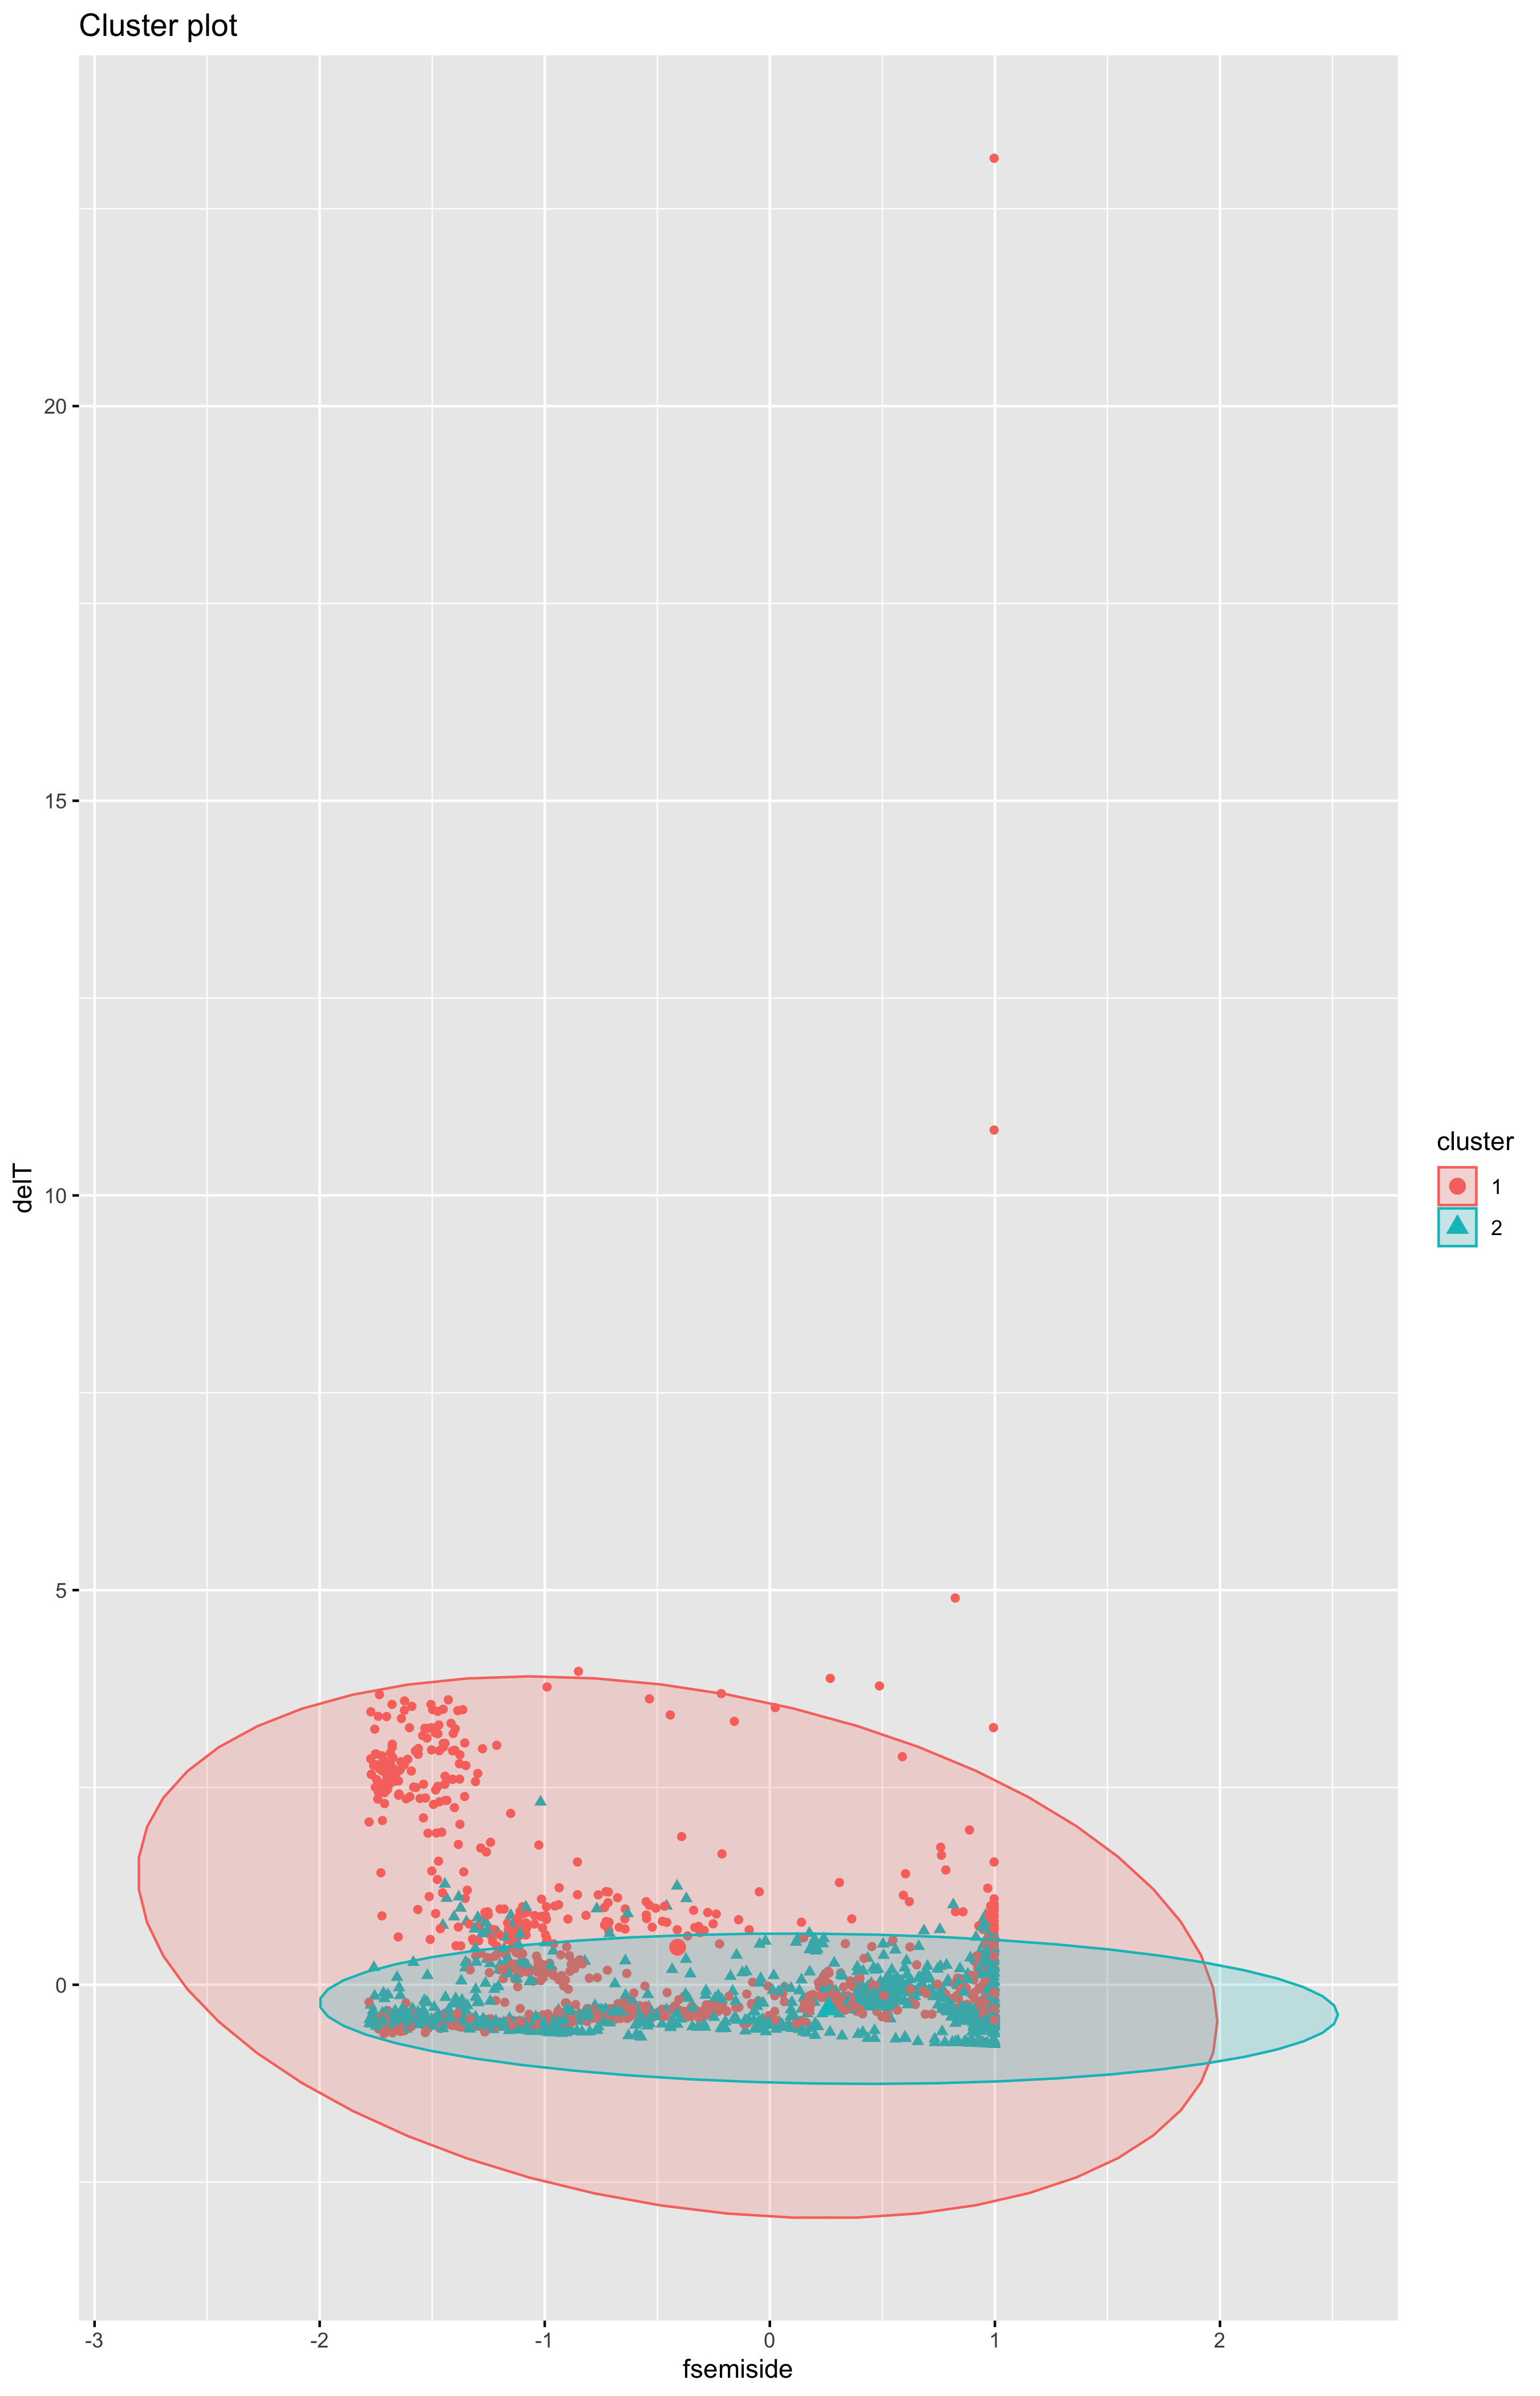

In [100]:
library(factoextra, warn.conflicts = FALSE)
fviz_cluster(km, data = comp_matrix, choose.vars = c("fsemiside", "delT"), geom = "point", centroids = TRUE, repel = TRUE, ellipse.type = "norm")


In [101]:
training_set <- useful_data |> add_column(class = factor(km$cluster, levels = c(1, 2), labels = c("bad", "good")))


In [102]:
training_set |>
    filter(class == "bad") |>
    select(variable, starts_with("identifier"), anagrafica.x, delT, climatdelT, sdT, f0, fsemiside)


variable,identifier.x,identifier.y,anagrafica.x,delT,climatdelT,sdT,f0,fsemiside
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T_MIN,7332,TN_PIE_CN_ACCEGLIO_02_000108500,ACCEGLIO,0.2195535,0.6913950,0.2257385,0.223248653,0.7744419
T_MIN,14098,TN_SIC_CT_ACIREALE_01_000469700,ACIREALE,1.3055557,1.4990537,1.2158136,0.000000000,0.5555556
T_MIN,7533,TN_PIE_CN_ALBA_02_000065200,ALBA TANARO,0.1798897,0.6027454,0.2249866,0.302407222,0.6970913
T_MIN,8462,TN_FVG_UD_ALESSO_02_000401500,ALESSO,0.5854315,1.0201772,0.9709472,0.359898477,0.5781726
T_MIN,7348,TN_PIE_VB_ALPE_DEVERO_02_000108200,ALPE DEVERO,0.4426803,0.9626634,0.5572093,0.179763186,0.8067815
T_MIN,7596,TN_PIE_VB_ALPE_VEGLIA_02_000288900,ALPE VEGLIA,0.2468085,0.6294122,0.3507478,0.232522796,0.7454407
T_MIN,7476,TN_PIE_TO_ANDRATE_PINALBA_02_000244000,ANDRATE PINALBA,0.3095057,0.5844888,0.3619783,0.187832700,0.8114068
T_MIN,8381,TN_FVG_UD_FORNI_DI_SOPRA_02_000231300,ANDRAZZA,0.5281333,0.3612111,1.0928834,0.488056620,0.6906517
T_MIN,11143,TN_ABR_AQ_ANVERSA_DEGLI_ABRUZZI_01_000321000,ANVERSA (ex CENT.LE ANVERSA),0.7155525,1.1892945,0.7291386,0.054570259,0.7803547


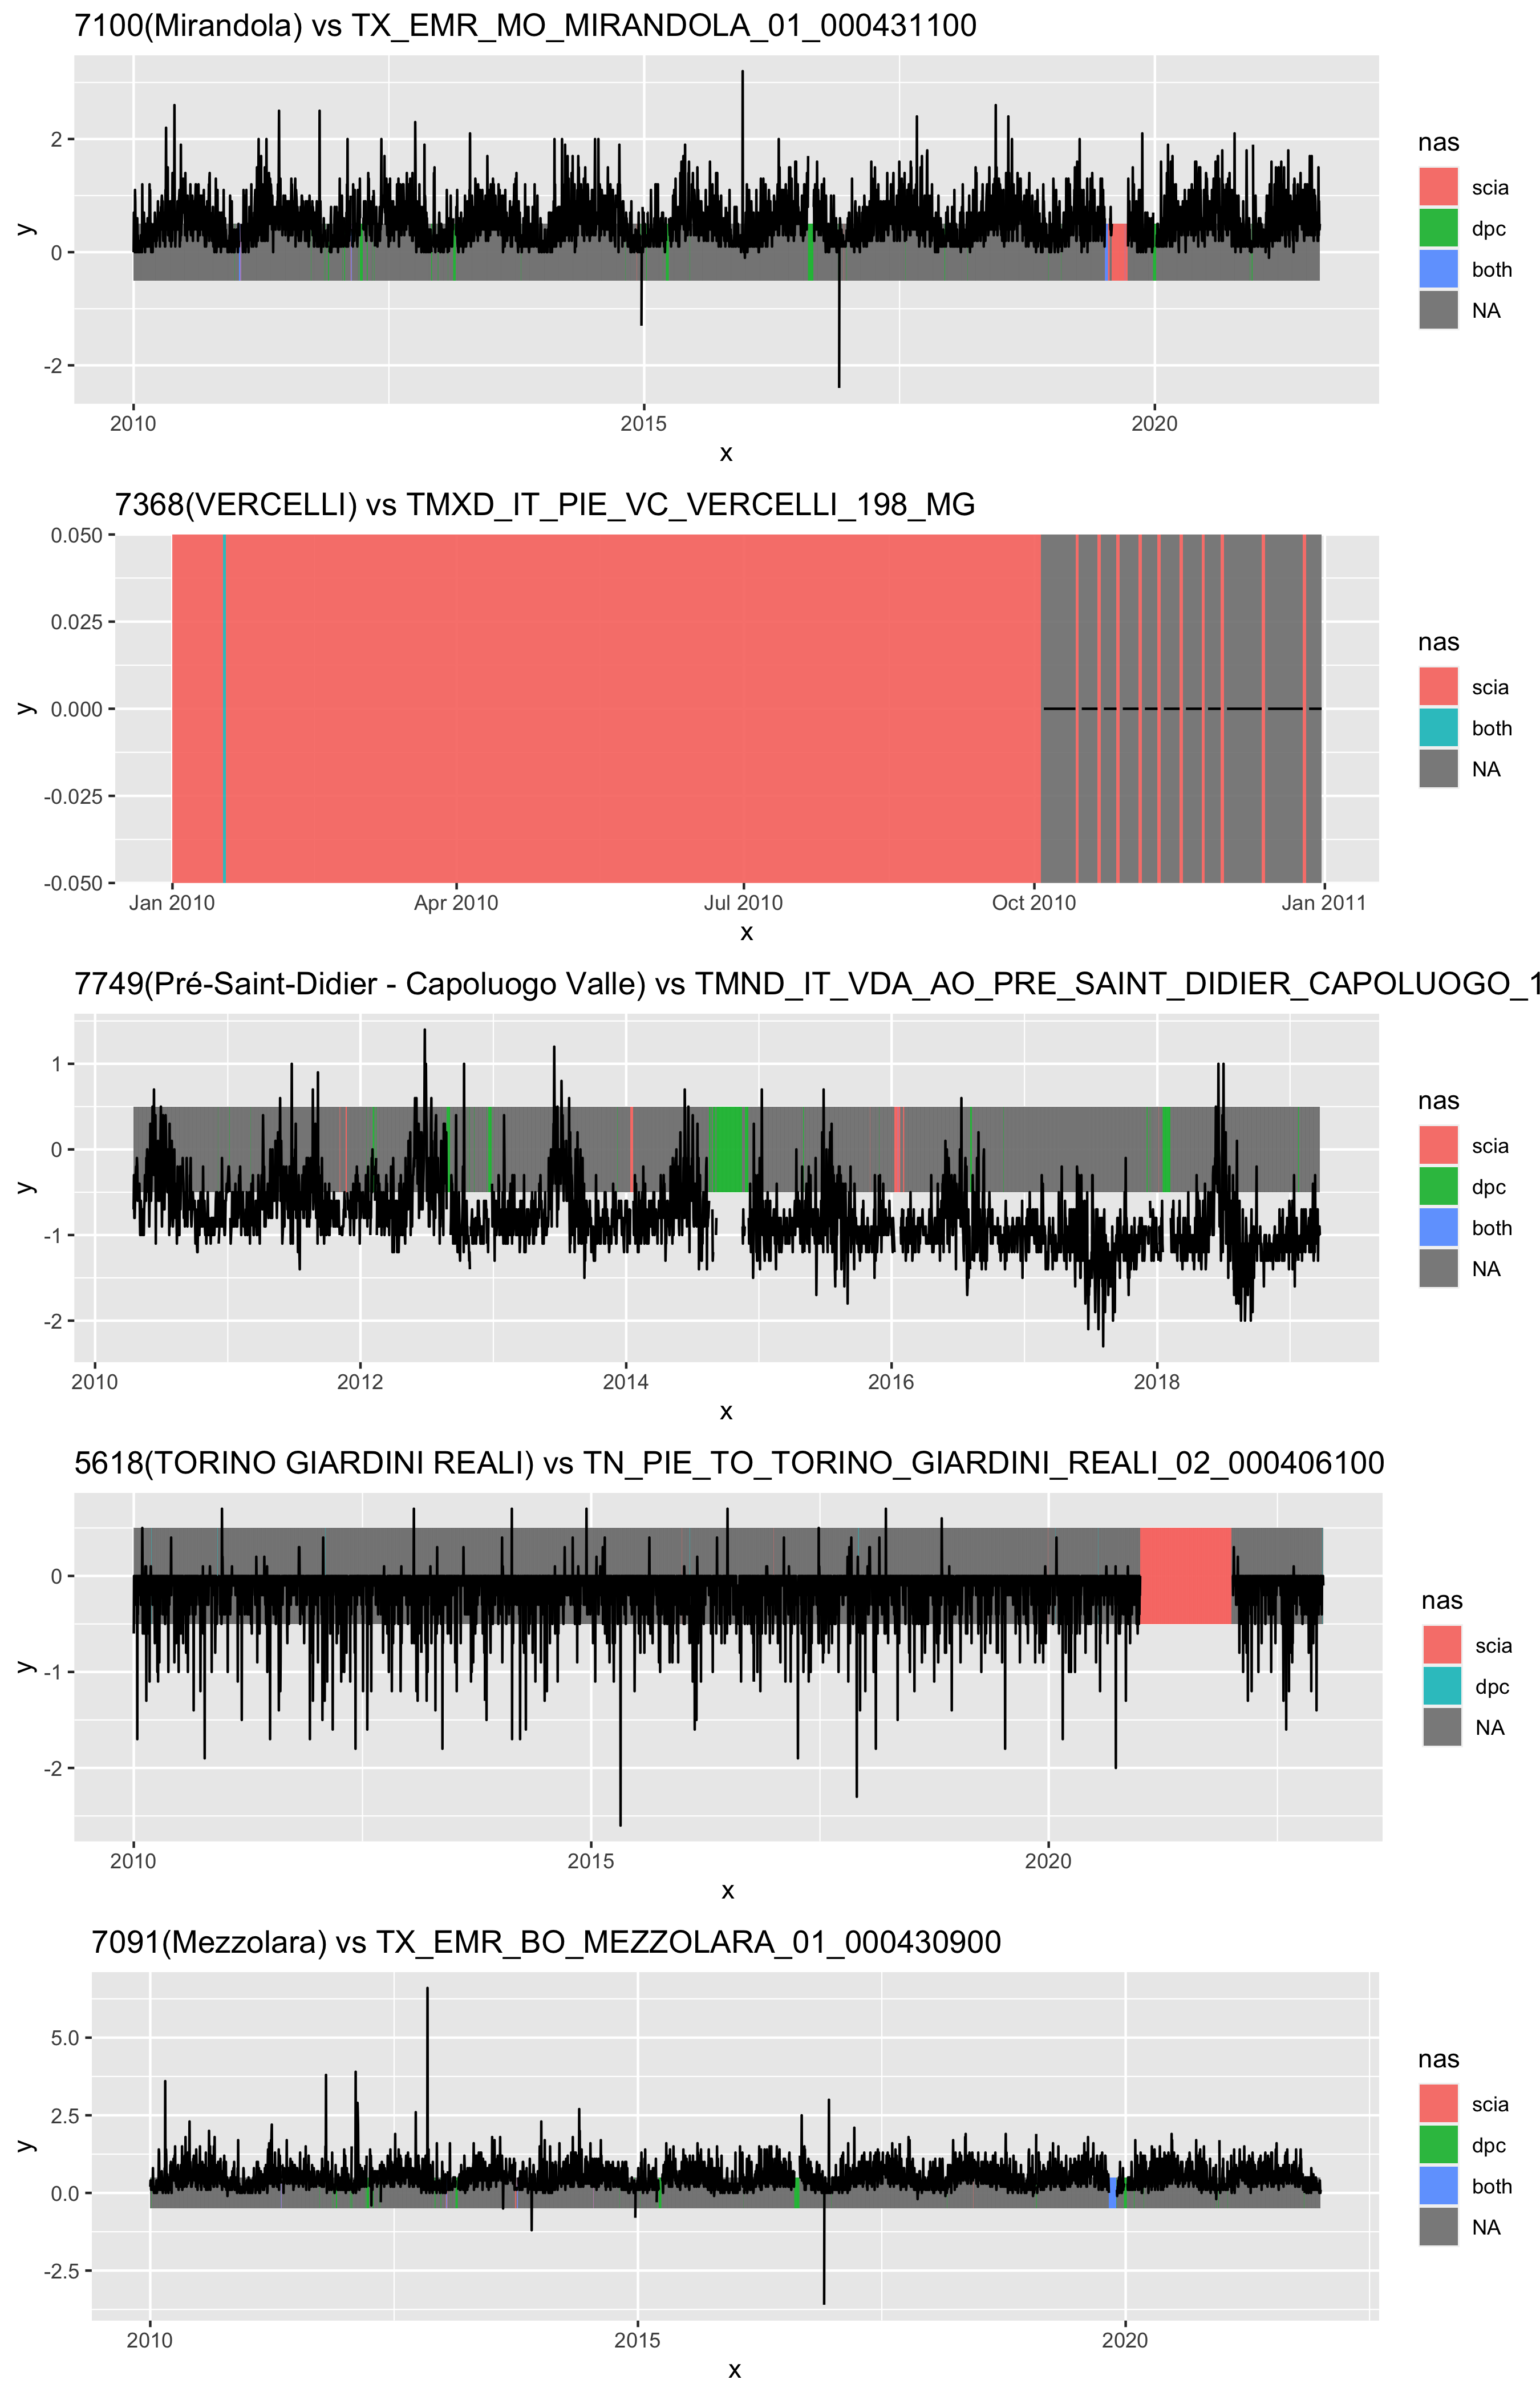

In [110]:
options(repr.plot.height = 14, repr.plot.res = 300)

plots <- training_set |>
    filter(class == "good") |>
    sample_n(size = 5) |>
    select(variable, starts_with("identifier"), anagrafica.x) |>
    rowwise() |>
    group_map(~ plot.sciavsdpc(.x[["variable"]], .x[["identifier.x"]], .x[["identifier.y"]], "qc_era5", start_date = "2010-01-01", anagrafica.scia = .x[["anagrafica.x"]]))
# plot.sciavsdpc("T_MIN", 7158, "TN_LIG_GE_ALPE_GORRETO_02_000297900", "qc_era5", start_date = "2022-01-01")
library(ggpubr, warn.conflicts = FALSE)
ggarrange(plotlist = plots, ncol = 1)

In [61]:
filter(training_set, str_detect(anagrafica.y, "GRESSONEY_LA_TRINITE"), variable == "T_MAX") |> sensible_columns(class)


variable,identifier.x,anagrafica.x,anagrafica.y,version,distance,strSym,fsemiside,delH,delT,delTint,sdT,corT,climatdelT,overlap,minilap,matches.x,matches.y,class
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>
T_MAX,7710,Gressoney-La-Trinit<U+00E9> - Alpe Courtlys,GRESSONEY_LA_TRINITE_ALPE_COURTLYS,NA,3.112341,0.9547893,0.9933921,103,1.4053047,1.4034508,1.207643,0.9824350,1.921496,0.6961081,0.9104278,10,4,bad
T_MAX,7712,Gressoney-La-Trinit<U+00E9> - Gabiet,GRESSONEY_LA_TRINITE_GABIET,NA,1.565983,0.9359903,0.9528787,1,0.8945261,0.8970771,1.182028,0.9823932,1.135085,0.6915637,0.8513045,12,5,good


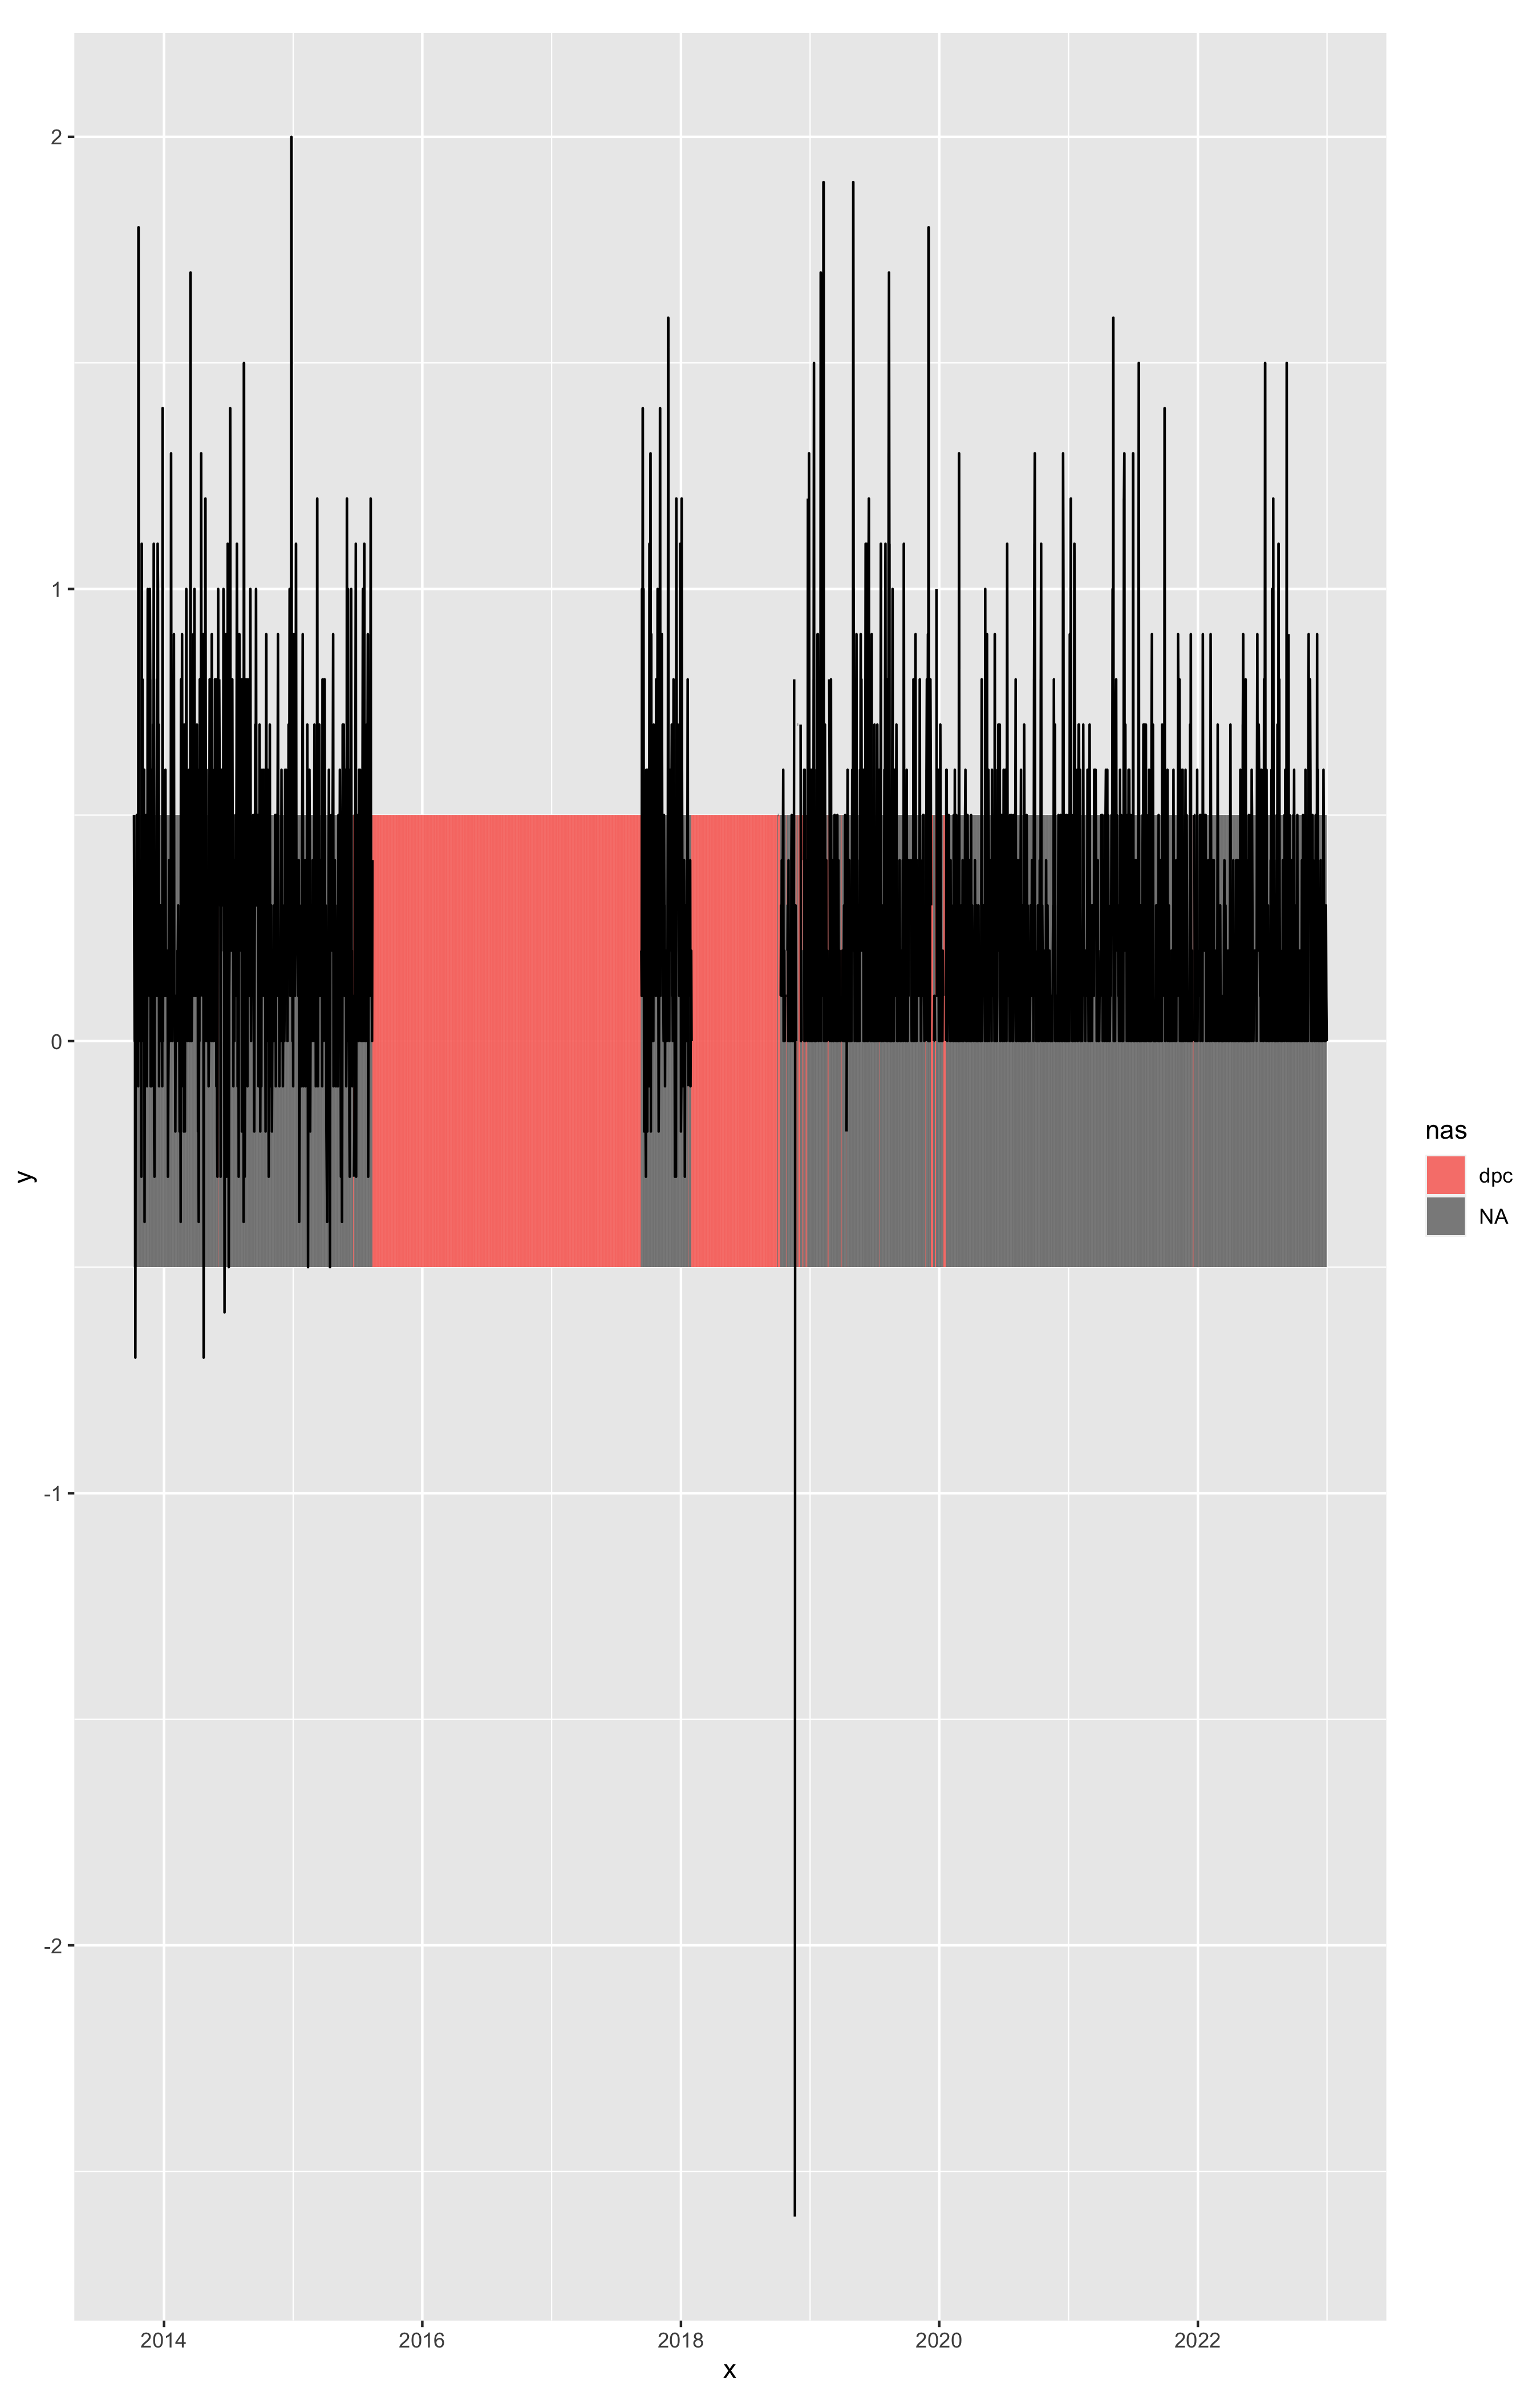

In [86]:
plot.sciavsdpc("T_MAX", 5742, "TX_VEN_VI_VALLI_DEL_PASUBIO_CMT_01_200251203", "qc_era5")